In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# this function is used to visualise the confusion matrix for the model
def visualize_preds(table,y_true, y_pred, title):
    ls = []
    f = plt.figure(figsize = (8,8))
    cf = confusion_matrix(y_true, y_pred)
    sb.heatmap(cf, fmt='.0f', annot=True)
    
    accuracy  = np.trace(cf) / float(np.sum(cf))

    # Metrics for Binary Confusion Matrices
    if sum(cf[:,1]) == 0:
        precision = 0.0;
    else:
        precision = cf[1,1] / sum(cf[:,1])
        
    if sum(cf[1,:]) == 0:
        recall = 0.0;
    else:
        recall    = cf[1,1] / sum(cf[1,:])
        
    if (precision + recall) == 0:
        f1_score = 0.0;
    else:
        f1_score  = 2 *precision * recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy,precision,recall,f1_score)
    
    ls.append(accuracy)
    ls.append(precision)
    ls.append(recall)
    ls.append(f1_score)
    ls = pd.DataFrame(ls)
    table = pd.concat([table,ls], axis = 1)
    
    plt.xlabel('Predicted' + stats_text)
    plt.ylabel('Actual')
    plt.title(title)
    
    return table

In [4]:
table1 = pd.DataFrame()
table2 = pd.DataFrame()

In [5]:
# importing clean data
cleanTrainData = pd.read_csv('clean-train-data.csv')
cleanTrainData = cleanTrainData.drop(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE', 'Risk_Class'], axis = 1)
cleanTrainData.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,3,13,0
1,7574516,40,10,9,13,0
2,3991815,66,4,4,10,0
3,6256451,41,2,2,12,1
4,5768871,47,11,3,14,1


# Classification of Train by Logistic Regression

In [6]:
# Getting the X_train, X_vali, y_train and y_vali data
y = pd.DataFrame(cleanTrainData['Risk_Flag'])
X = pd.DataFrame(cleanTrainData.drop('Risk_Flag',axis = 1))

# Split the Dataset into Train and Test
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size = 0.25)

In [7]:
# Correlation between the variables
cleanTrainData.corr()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Income,1.000000,-0.000652,0.006422,0.007045,-0.002397,-0.003091
Age,-0.000652,1.000000,-0.001118,0.002154,-0.020134,-0.021809
Experience,0.006422,-0.001118,1.000000,0.646098,0.019309,-0.034523
CURRENT_JOB_YRS,0.007045,0.002154,0.646098,1.000000,0.005372,-0.016942
CURRENT_HOUSE_YRS,-0.002397,-0.020134,0.019309,0.005372,1.000000,-0.004375
Risk_Flag,-0.003091,-0.021809,-0.034523,-0.016942,-0.004375,1.000000


In [8]:
#Calculate the odds of having Risk
print("The odds of having risk in train dataset is\t: ", y_train.value_counts()[1]/y_train.value_counts()[0])

#Perform the logistics regression
logreg1 = LogisticRegression()
 
#Fit the data
logreg1.fit(X_train,y_train)

#Print out the mean acuuracy
print("The overall classification accuracy \t\t: ", logreg1.score(X_vali,y_vali))

The odds of having risk in train dataset is	:  0.1398451258051287


/Users/eecheerlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The overall classification accuracy 		:  0.8760634920634921


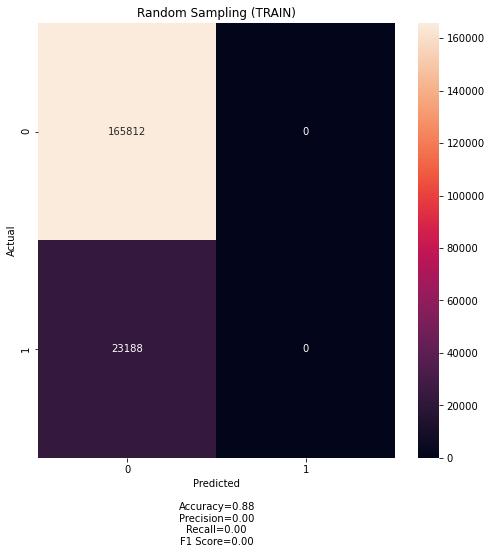

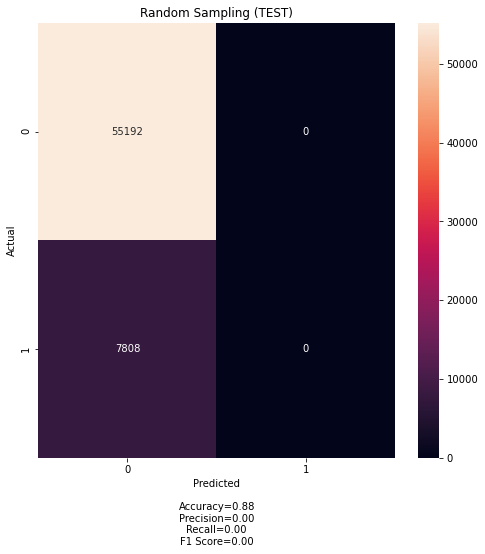

In [9]:
#Predicting the data
y_train_pred = logreg1.predict(X_train)
y_vali_pred = logreg1.predict(X_vali)

#Visualizing the data
table1 = visualize_preds(table1,y_train,y_train_pred, title = 'Random Sampling (TRAIN)')
table2 = visualize_preds(table2,y_vali,y_vali_pred, title = 'Random Sampling (TEST)')

For this model, there is a high classification accuracy of 0.88. This may be due to the large imbalance in the dataset.

# Classification of Train by Logistic Regression with upsampling

In [10]:
from sklearn.utils import resample
risk = cleanTrainData[cleanTrainData["Risk_Flag"] == 1]
no_risk  = cleanTrainData[cleanTrainData["Risk_Flag"] == 0]

risk_upsample = resample(risk,
             replace=True,
             n_samples=no_risk.shape[0])

combinedData_up = pd.concat([no_risk, risk_upsample])
print(combinedData_up.shape)

(442008, 6)


In [11]:
# Getting the X_train, X_vali, y_train and y_vali data
y = pd.DataFrame(combinedData_up['Risk_Flag'])
X = pd.DataFrame(combinedData_up.drop('Risk_Flag',axis = 1))

# Split the Dataset into Train and Test
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size = 0.25)

In [12]:
#Calculate the odds of having Risk
print("The odds of having risk in train dataset is\t: ", y_train.value_counts()[1]/y_train.value_counts()[0])

#Perform the logistics regression
logreg1 = LogisticRegression()
 
#Fit the data
logreg1.fit(X_train,y_train)

#Print out the mean acuuracy
print("The overall classification accuracy \t\t: ", logreg1.score(X_vali,y_vali))

The odds of having risk in train dataset is	:  0.9992280646737065
The overall classification accuracy 		:  0.4994208249624441


/Users/eecheerlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


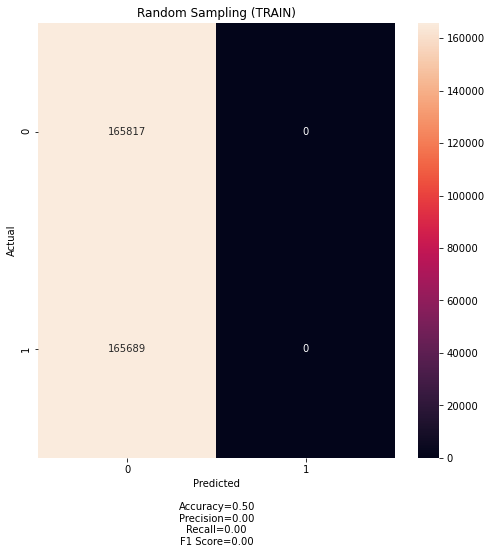

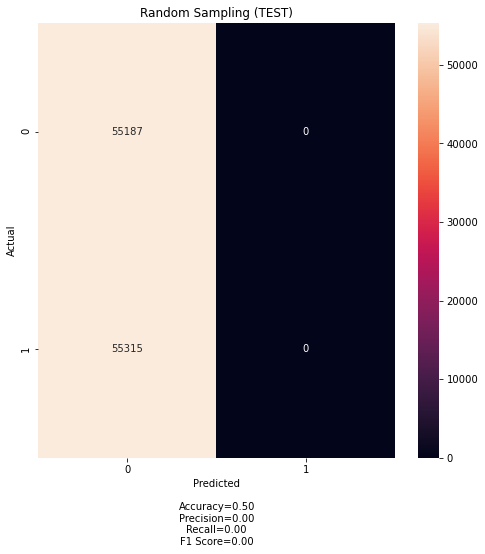

In [13]:
#Predicting the data
y_train_pred = logreg1.predict(X_train)
y_vali_pred = logreg1.predict(X_vali)

#Visualizing the data
table1 = visualize_preds(table1,y_train,y_train_pred, title = 'Random Sampling (TRAIN)')
table2 = visualize_preds(table2,y_vali,y_vali_pred, title = 'Random Sampling (TEST)')

After upsampling the data, the overall classification accuracy has reduced to 0.50 which can be a better model in predicting `Risk_Flag`. However, there is data leakage due to upsampling and we have thus decided to downsample our data to solve this issue.

# Classification of Train by Logistic Regression with downsampling

In [14]:
risk = cleanTrainData[cleanTrainData["Risk_Flag"] == 1]
no_risk  = cleanTrainData[cleanTrainData["Risk_Flag"] == 0]

no_risk_downsample = resample(no_risk,
             replace=True,
             n_samples=risk.shape[0])

combinedData_down = pd.concat([risk, no_risk_downsample])
print(combinedData_down.shape)

(61992, 6)


In [15]:
# Getting the X_train, X_vali, y_train and y_vali data
y = pd.DataFrame(combinedData_down['Risk_Flag'])
X = pd.DataFrame(combinedData_down.drop('Risk_Flag',axis = 1))

# Split the Dataset into Train and Test
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size = 0.25)

In [16]:
#Calculate the odd of a movie is good
print("The odds of having risk in train dataset is\t: ", y_train.value_counts()[1]/y_train.value_counts()[0])

#Perform the logistics regression
logreg1 = LogisticRegression()
 
#Fit the data
logreg1.fit(X_train,y_train)

#Print out the mean acuuracy
print("The overall classification accuracy \t\t: ", logreg1.score(X_vali,y_vali))

The odds of having risk in train dataset is	:  0.9963931469792606
The overall classification accuracy 		:  0.497289972899729


/Users/eecheerlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


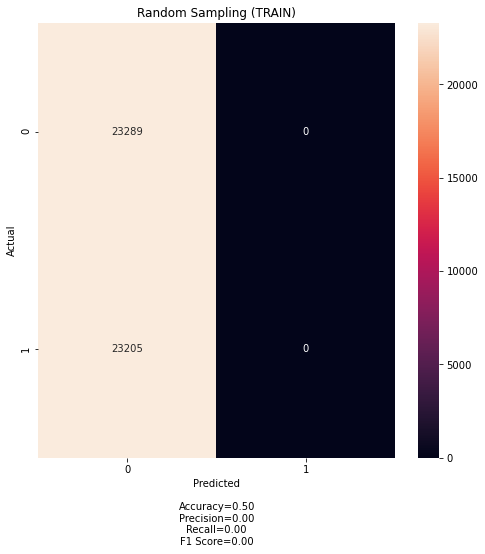

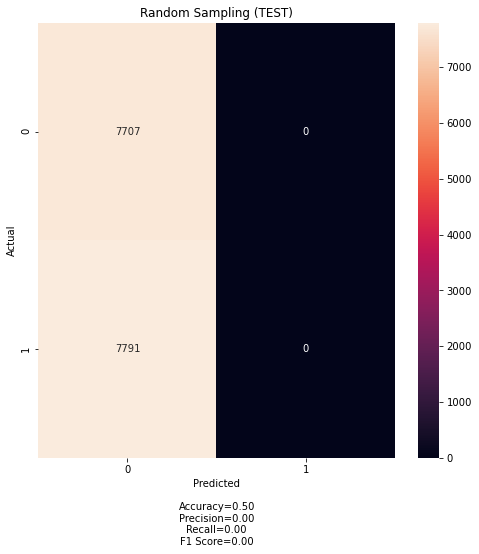

In [17]:
#Predicting the data
y_train_pred = logreg1.predict(X_train)
y_vali_pred = logreg1.predict(X_vali)

#Visualizing the data
table1 = visualize_preds(table1,y_train,y_train_pred, title = 'Random Sampling (TRAIN)')
table2 = visualize_preds(table2,y_vali,y_vali_pred, title = 'Random Sampling (TEST)')

After downsampling our data, our logistic regression model still has a classification accuracy of around 0.5. However, with this model, data leakage has been accounted for which makes it a better model. 

Unlike linear regression where we use the predictors to predict the numeric response variable, logistic regression uses the predictors to predict a categorical response variable. Even though our logistic regression model may not be the most accurate, we have learnt that such a model to predict categorical variables exist and perhaps we can use it for other projects in the future.